# Image quantization aware training
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from joblib import dump
import matplotlib.pyplot as plt

from image_model_optimization import *
from image_model_training import get_image_model, get_image_datasets, normalize_dataset, augment_data, IMG_SHAPE, AUTOTUNE

## Parámetros
Se establecen los parámetros para la optimización.

In [2]:
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
original_model_name = "MicroImgDataModel"
checkpoint_dir = f"{saved_models_dir}/tensorflow/checkpoints"
label_index_dir = f"{saved_models_dir}/label index mappings"

model_name = f"{original_model_name}QAT"
checkpoint_path = f"{checkpoint_dir}/{model_name}.hdf5"

data_dir = f"{project_dir}/samples/microcontroller/preprocessed image/train"
log_dir = f"{saved_models_dir}/summaries/{model_name}"
model_dir = f"{saved_models_dir}/tensorflow/{model_name}"

validation_percentage = 20.
initial_learning_rate = 0.001
decay = (initial_learning_rate / QUANT_EPOCHS) * 1.5

## Carga de datos
Se cargan los mismos datasets de entrenamiento y validación que se han usado en el entrenamiento.

In [3]:
train_dataset, validation_dataset = get_image_datasets(data_dir, validation_percentage)
class_names = train_dataset.class_names
train_dataset = augment_data(train_dataset, IMG_SHAPE)
# validation_dataset = augment_data(validation_dataset, IMG_SHAPE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

nclasses = len(class_names)

class_list_text = "Classes:"
for index, name in enumerate(class_names):
    class_list_text += f"\n\t{index}: {name}"

print(class_list_text)
with open(f"{label_index_dir}/{model_name}.txt", "wt") as text_file:
    text_file.write(class_list_text)

dump(class_names, f"{label_index_dir}/{model_name}.joblib")

# Estas operaciones no se pueden aplicar a los datos en el microcontrolador.
# train_dataset = normalize_dataset(train_dataset)
# validation_dataset = normalize_dataset(validation_dataset)

Found 274 files belonging to 3 classes.
Using 220 files for training.
Found 274 files belonging to 3 classes.
Using 54 files for validation.
Classes:
	0: face
	1: mask
	2: nothing


['/home/daniel/PycharmProjects/tfg-tinyml/saved models/image/label index mappings/MicroImgDataModelQAT.joblib']

## Quantization aware training
Como no sirve el modelo entrenado anteriormente debido a que para usar quantization-aware training hay que eliminar una
capa primero se entrena si cuantizar un nuevo modelo y luego se reentrena usando quantization-aware training.

In [4]:
def lr_time_based_decay(epoch: int, lr: float) -> float:
    """
    Callback function que reduce el learning rate conforme avanza el entrenamiento.
    Args:
        epoch:  int que representa el epoch del entrenamiento que se va a realizar a continuación.
        lr:     float con el learning rate del último epoch.

    Returns:
        float con el nuevo learning rate
    """
    return lr * 1 / (1 + decay * epoch)

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy',
                                            mode='max', save_best_only=True, verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', verbose=1, patience=QUANT_PATIENCE)

callbacks = [LearningRateScheduler(lr_time_based_decay, verbose=1), model_checkpoint_callback, early_stopping_callback]

model = get_image_model(nclasses, model_name, normalization_layer=False)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=QUANT_EPOCHS,
    callbacks=callbacks
)

model.load_weights(checkpoint_path)

model = tfmot.quantization.keras.quantize_model(model)

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=QUANT_EPOCHS,
    callbacks=callbacks
)

model.load_weights(checkpoint_path)

Model: "MicroImgDataModelQAT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 97, 97, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 4)         36        
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 4)         16        
_________________________________________________________________
re_lu (ReLU)                 (None, 48, 48, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 8)         288       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 8)         32        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 48, 48, 8)

## Visualización de historial de entrenamiento

Se visualiza accuracy y loss de training y validation.

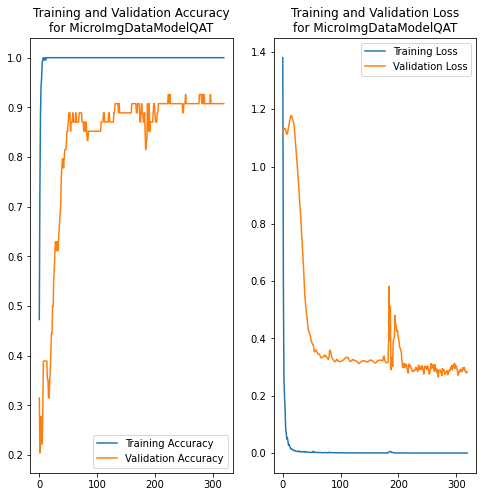

In [5]:
acc = tf.concat([history1.history["accuracy"], history2.history["accuracy"]], 0)
val_acc = tf.concat([history1.history["val_accuracy"], history2.history["val_accuracy"]], 0)

loss = tf.concat([history1.history["loss"], history2.history["loss"]], 0)
val_loss = tf.concat([history1.history["val_loss"], history2.history["val_loss"]], 0)

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title(f"Training and Validation Accuracy\nfor {model_name}")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title(f"Training and Validation Loss\nfor {model_name}")

plt.savefig(f"{log_dir}/{model_name}_training_data.jpg")

plt.show()

## Guardar modelo
Guardamos el modelo entrenado para poder reutilizarlo en el futuro.

In [6]:
tf.keras.models.save_model(model, model_dir)

INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/MicroImgDataModelQAT/assets


INFO:tensorflow:Assets written to: /home/daniel/PycharmProjects/tfg-tinyml/saved models/image/tensorflow/MicroImgDataModelQAT/assets
